In [1]:
%env DB_HOST=mongodb://localhost/openpath_prod_stm_community
import emission.core.get_database as edb
import emission.storage.timeseries.aggregate_timeseries as esta
import emission.storage.timeseries.builtin_timeseries as estb
import emission.core.get_database as gdb

env: DB_HOST=mongodb://localhost/openpath_prod_stm_community
Config file not found, returning a copy of the environment variables instead...
Retrieved config: {'DB_HOST': 'mongodb://localhost/openpath_prod_stm_community', 'DB_RESULT_LIMIT': None}
Connecting to database URL mongodb://localhost/openpath_prod_stm_community


In [ ]:
pipeline_docs_cursor = gdb.get_timeseries_db().find({
    "metadata.key": "stats/pipeline_time",
})

# Display a sample of the documents
import pprint
pipeline_docs = list(pipeline_docs_cursor)
if pipeline_docs:
    single_doc = pipeline_docs[0]
    print("Single Document:")
    pprint.pprint(single_doc)
else:
    print("No documents found for 'stats/pipeline_time'.")

# Fetch multiple documents
pipeline_docs_sample = pipeline_docs[:5]  # Get first 5 documents
print("\nMultiple Documents:")
for doc in pipeline_docs_sample:
    pprint.pprint(doc)


In [3]:
import pandas as pd
from datetime import datetime, timedelta
import pytz

df = pd.json_normalize(pipeline_docs)
df.describe()


,metadata.write_ts,metadata.write_local_dt.year,metadata.write_local_dt.month,metadata.write_local_dt.day,metadata.write_local_dt.hour,metadata.write_local_dt.minute,metadata.write_local_dt.second,metadata.write_local_dt.weekday,data.ts,data.reading
count,2.398700e+04,23987.0,23987.000000,23987.000000,23987.000000,23987.000000,23987.000000,23987.000000,2.398700e+04,23987.000000
mean,1.727713e+09,2024.0,9.463710,16.023638,12.385876,6.197190,35.156835,3.031058,1.727713e+09,1.362160
std,3.153198e+06,0.0,1.235626,9.140212,6.285743,0.519658,9.796555,1.983778,3.153198e+06,7.713220
min,1.721844e+09,2024.0,7.000000,1.000000,0.000000,6.000000,0.000000,0.000000,1.721844e+09,0.007320
25%,1.725243e+09,2024.0,9.000000,8.000000,8.000000,6.000000,34.000000,1.000000,1.725243e+09,0.033075
50%,1.727828e+09,2024.0,10.000000,16.000000,13.000000,6.000000,35.000000,3.000000,1.727828e+09,0.062737
75%,1.730182e+09,2024.0,10.000000,25.000000,18.000000,6.000000,37.000000,5.000000,1.730182e+09,0.468138
max,1.733591e+09,2024.0,12.000000,31.000000,23.000000,11.000000,59.000000,6.000000,1.733591e+09,286.118971


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23987 entries, 0 to 23986
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   _id                               23987 non-null  object 
 1   user_id                           23987 non-null  object 
 2   metadata.key                      23987 non-null  object 
 3   metadata.platform                 23987 non-null  object 
 4   metadata.write_ts                 23987 non-null  float64
 5   metadata.time_zone                23987 non-null  object 
 6   metadata.write_local_dt.year      23987 non-null  int64  
 7   metadata.write_local_dt.month     23987 non-null  int64  
 8   metadata.write_local_dt.day       23987 non-null  int64  
 9   metadata.write_local_dt.hour      23987 non-null  int64  
 10  metadata.write_local_dt.minute    23987 non-null  int64  
 11  metadata.write_local_dt.second    23987 non-null  int64  
 12  meta

In [5]:
name = df['data.name'].unique()
print(name)

['USERCACHE' 'CREATE_CONFIRMED_OBJECTS' 'CREATE_COMPOSITE_OBJECTS'
 'TRIP_SEGMENTATION' 'SECTION_SEGMENTATION' 'JUMP_SMOOTHING'
 'MODE_INFERENCE' 'USER_INPUT_MATCH_INCOMING' 'ACCURACY_FILTERING'
 'CLEAN_RESAMPLING' 'LABEL_INFERENCE' 'EXPECTATION_POPULATION'
 'STORE_USER_STATS']


In [6]:
# import pandas as pd

# # Step 1: Filter for rows where data.name is "USERCACHE"
# usercache_df = df[df['data.name'] == "USERCACHE"]

# # Step 2: Convert metadata.write_ts to datetime
# usercache_df['datetime'] = pd.to_datetime(usercache_df['metadata.write_ts'], unit='s')

# # Step 3: Define the start date for filtering
# start_date = pd.Timestamp('2024-11-08')  # Adjust as needed

# # Step 4: Filter for rows since the start date
# usercache_df = usercache_df[usercache_df['datetime'] >= start_date]

# # Step 5: Group by hour and count executions
# hourly_execution_counts = usercache_df.groupby(usercache_df['datetime'].dt.floor('H')).size()

# # Step 6: Output the results
# if hourly_execution_counts.empty:
#     print("No executions of 'USERCACHE' since November 8.")
# else:
#     print("Hourly execution counts since November 8:")
#     print(hourly_execution_counts)


In [7]:
import os


# Step 0: Define the list of 'data.name' entries to exclude
# These are the 'Parent' functions
exclude_data_names = [
    'TRIP_SEGMENTATION/segment_into_trips',
    'TRIP_SEGMENTATION/segment_into_trips_dist/loop'
]

# Step 1: Filter for function-level data only (entries with slashes in 'data.name') and exclude specified names
function_level_df = df[
    df['data.name'].str.contains('/') &
    ~df['data.name'].isin(exclude_data_names)
].copy()

# Step 2: Select the relevant columns
selected_columns = function_level_df[['data.reading', 'data.name']].copy()

# Step 3: Data Cleaning
# Drop rows with missing values in 'data.reading' or 'data.name'
selected_columns.dropna(subset=['data.reading', 'data.name'], inplace=True)

# Ensure 'data.reading' is numeric
selected_columns = selected_columns[pd.to_numeric(selected_columns['data.reading'], errors='coerce').notnull()]


# Step 5: Aggregate 'data.reading' by 'data.name'

# Aggregation Using Sum
aggregated_sum = selected_columns.groupby('data.name', as_index=False)['data.reading'].sum()
aggregated_sum.rename(columns={'data.reading': 'total_reading'}, inplace=True)

# Aggregation Using Mean
aggregated_mean = selected_columns.groupby('data.name', as_index=False)['data.reading'].mean()
aggregated_mean.rename(columns={'data.reading': 'average_reading'}, inplace=True)

# Step 6: Determine the 80th percentile threshold based on aggregated values

# For Sum Aggregation
threshold_sum = aggregated_sum['total_reading'].quantile(0.80)

# For Mean Aggregation
threshold_mean = aggregated_mean['average_reading'].quantile(0.80)

# For Total Aggregation
threshold_total = selected_columns['data.reading'].quantile(0.80)

# Step 7: Split the DataFrame into top 20% and bottom 80% based on aggregated values

# Using Sum Aggregation
top20_sum = aggregated_sum[aggregated_sum['total_reading'] >= threshold_sum].sort_values(by='total_reading', ascending=False)
bottom80_sum = aggregated_sum[aggregated_sum['total_reading'] < threshold_sum].sort_values(by='total_reading', ascending=False)
top20_total = selected_columns[selected_columns['data.reading'] >= threshold_total].sort_values(by='data.reading', ascending=False)
bottom80_total = selected_columns[selected_columns['data.reading'] < threshold_total].sort_values(by='data.reading', ascending=False)

# Using Mean Aggregation
top20_mean = aggregated_mean[aggregated_mean['average_reading'] >= threshold_mean].sort_values(by='average_reading', ascending=False)
bottom80_mean = aggregated_mean[aggregated_mean['average_reading'] < threshold_mean].sort_values(by='average_reading', ascending=False)

# Step 8: Define the base directory and file paths
base_dir = os.getcwd()  # Current working directory

# Paths for Sum Aggregation
aggregated_sum_path = os.path.join(base_dir, 'aggregated_sum_function_level_3.csv')
top20_sum_path = os.path.join(base_dir, 'top20_function_level_sum_sorted_3.csv')
bottom80_sum_path = os.path.join(base_dir, 'bottom80_function_level_sum_sorted_3.csv')
top20_total_path = os.path.join(base_dir, 'top20_function_level_sum_sorted_3.csv')
bottom80_total_path = os.path.join(base_dir, 'bottm80_function_level_sum_sorted_3.csv')

# Paths for Mean Aggregation
aggregated_mean_path = os.path.join(base_dir, 'aggregated_mean_function_level_3.csv')
top20_mean_path = os.path.join(base_dir, 'top20_function_level_mean_sorted_3.csv')
bottom80_mean_path = os.path.join(base_dir, 'bottom80_function_level_mean_sorted_3.csv')

# Step 9: Save the aggregated and categorized DataFrames to CSV files

# Saving Sum Aggregation
aggregated_sum.to_csv(aggregated_sum_path, index=False)
top20_sum.to_csv(top20_sum_path, index=False)
bottom80_sum.to_csv(bottom80_sum_path, index=False)
top20_total.to_csv(top20_total_path, index=False)
bottom80_total.to_csv(bottom80_total_path, index=False)

print(f"Aggregated Sum Function-Level Data saved to {aggregated_sum_path}")
print(f"Top 20% (Sum) function-level data saved to {top20_sum_path}")
print(f"Bottom 80% (Sum) function-level data saved to {bottom80_sum_path}")
print(f"Top 20%  function-level data saved to {top20_total_path}")
print(f"Bottom 80% function-level data saved to {bottom80_total_path}")

# Saving Mean Aggregation
aggregated_mean.to_csv(aggregated_mean_path, index=False)
top20_mean.to_csv(top20_mean_path, index=False)
bottom80_mean.to_csv(bottom80_mean_path, index=False)

print(f"\nAggregated Mean Function-Level Data saved to {aggregated_mean_path}")
print(f"Top 20% (Mean) function-level data saved to {top20_mean_path}")
print(f"Bottom 80% (Mean) function-level data saved to {bottom80_mean_path}")

# Step 10: Verify the splits
print(f"\nSum Aggregation - Top 20% row count: {len(top20_sum)}")
print(f"Sum Aggregation - Bottom 80% row count: {len(bottom80_sum)}")

print(f"\nMean Aggregation - Top 20% row count: {len(top20_mean)}")
print(f"Mean Aggregation - Bottom 80% row count: {len(bottom80_mean)}")

# Step 11: Inspect some entries
print("\nSample Top 20% Sum Aggregation Entries:")
print(top20_sum.head())

print("\nSample Bottom 80% Sum Aggregation Entries:")
print(bottom80_sum.head())

print("\nSample Top 20% Mean Aggregation Entries:")
print(top20_mean.head())

print("\nSample Bottom 80% Mean Aggregation Entries:")
print(bottom80_mean.head())


Aggregated Sum Function-Level Data saved to /Users/rsimpson/e-mission-server/aggregated_sum_function_level_3.csv
Top 20% (Sum) function-level data saved to /Users/rsimpson/e-mission-server/top20_function_level_sum_sorted_3.csv
Bottom 80% (Sum) function-level data saved to /Users/rsimpson/e-mission-server/bottom80_function_level_sum_sorted_3.csv
Top 20%  function-level data saved to /Users/rsimpson/e-mission-server/top20_function_level_sum_sorted_3.csv
Bottom 80% function-level data saved to /Users/rsimpson/e-mission-server/bottm80_function_level_sum_sorted_3.csv

Aggregated Mean Function-Level Data saved to /Users/rsimpson/e-mission-server/aggregated_mean_function_level_3.csv
Top 20% (Mean) function-level data saved to /Users/rsimpson/e-mission-server/top20_function_level_mean_sorted_3.csv
Bottom 80% (Mean) function-level data saved to /Users/rsimpson/e-mission-server/bottom80_function_level_mean_sorted_3.csv

Sum Aggregation - Top 20% row count: 0
Sum Aggregation - Bottom 80% row coun

In [8]:
def average_pipeline_time(combined_df):
    avg_time_df = combined_df.groupby('data.name')['data.reading'].mean().reset_index()
    avg_time_df.rename(columns={'data.reading': 'average_time'}, inplace=True)
    
    print("\nAverage Pipeline Time per Step:")
    print(avg_time_df.sort_values(by='average_time', ascending=False))
    
    # Optionally, save to CSV
    avg_time_df.to_csv('average_pipeline_time_per_step.csv', index=False)

average_pipeline_time(df)


Average Pipeline Time per Step:
                    data.name  average_time
10          TRIP_SEGMENTATION     24.363153
2    CREATE_COMPOSITE_OBJECTS      3.825797
8        SECTION_SEGMENTATION      2.764333
1            CLEAN_RESAMPLING      2.724287
7              MODE_INFERENCE      1.932568
3    CREATE_CONFIRMED_OBJECTS      1.335022
12  USER_INPUT_MATCH_INCOMING      0.811679
5              JUMP_SMOOTHING      0.588767
6             LABEL_INFERENCE      0.218143
9            STORE_USER_STATS      0.120387
11                  USERCACHE      0.102438
4      EXPECTATION_POPULATION      0.075575
0          ACCURACY_FILTERING      0.022724


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def pipeline_time_distribution(combined_df, step_name):
    step_df = combined_df[combined_df['data.name'] == step_name]
    
    if step_df.empty:
        print(f"No data found for step: {step_name}")
        return
    
    plt.figure(figsize=(10,6))
    sns.histplot(step_df['data.reading'], bins=30, kde=True)
    plt.title(f"Distribution of Pipeline Times for {step_name}")
    plt.xlabel("Pipeline Time (seconds)")
    plt.ylabel("Frequency")
    plt.show()

pipeline_time_distribution(df, 'TRIP_SEGMENTATION/segment_into_trips')

No data found for step: TRIP_SEGMENTATION/segment_into_trips


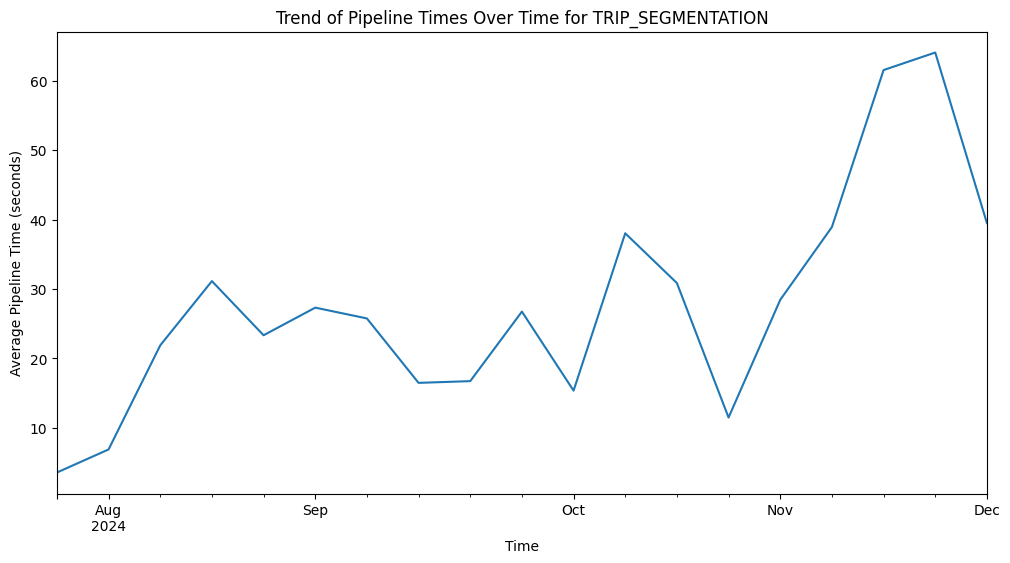

In [10]:
def pipeline_time_trends(combined_df, step_name, freq='D'):
    """
    Plots the trend of pipeline times over time for a specific step.
    :param freq: Resampling frequency ('D' for daily, 'W' for weekly, 'M' for monthly)
    """
    step_df = combined_df[combined_df['data.name'] == step_name].copy()
    
    if step_df.empty:
        print(f"No data found for step: {step_name}")
        return
    
    # Convert timestamp to datetime
    step_df['datetime'] = pd.to_datetime(step_df['metadata.write_ts'], unit='s')
    
    # Set datetime as index
    step_df.set_index('datetime', inplace=True)
    
    # Resample and calculate mean pipeline time
    resampled = step_df['data.reading'].resample(freq).mean()
    
    # Plotting
    plt.figure(figsize=(12,6))
    resampled.plot()
    plt.title(f"Trend of Pipeline Times Over Time for {step_name}")
    plt.xlabel("Time")
    plt.ylabel("Average Pipeline Time (seconds)")
    plt.show()

pipeline_time_trends(df, 'TRIP_SEGMENTATION', 'W')


Top 5 Bottleneck Pipeline Steps:
Empty DataFrame
Columns: [data.name, average_time]
Index: []


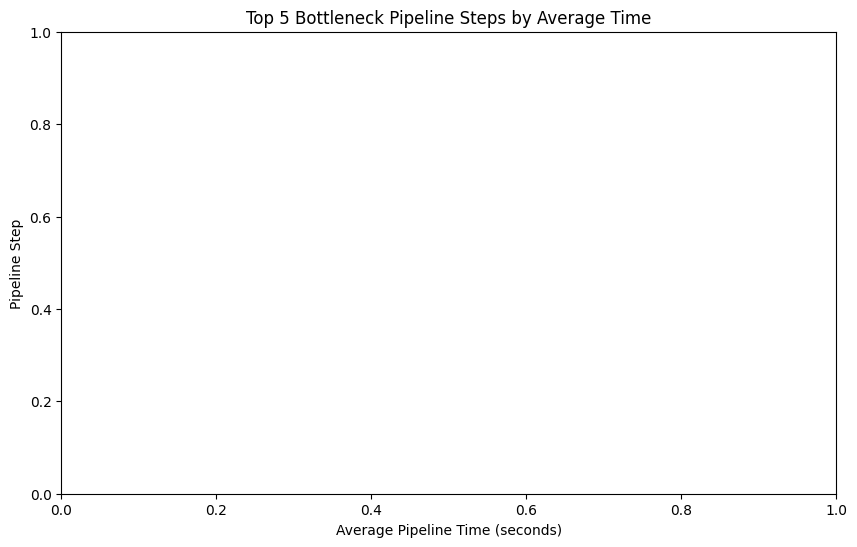

In [11]:
def identify_bottlenecks(combined_df, top_n=5):
    avg_time_df = combined_df.groupby('data.name')['data.reading'].mean().reset_index()
    avg_time_df.rename(columns={'data.reading': 'average_time'}, inplace=True)
    
    bottlenecks = avg_time_df.sort_values(by='average_time', ascending=False).head(top_n)
    
    print(f"\nTop {top_n} Bottleneck Pipeline Steps:")
    print(bottlenecks)
    
    # Optionally, visualize
    plt.figure(figsize=(10,6))
    sns.barplot(x='average_time', y='data.name', data=bottlenecks, palette='viridis')
    plt.title(f"Top {top_n} Bottleneck Pipeline Steps by Average Time")
    plt.xlabel("Average Pipeline Time (seconds)")
    plt.ylabel("Pipeline Step")
    plt.show()

identify_bottlenecks(function_level_df)

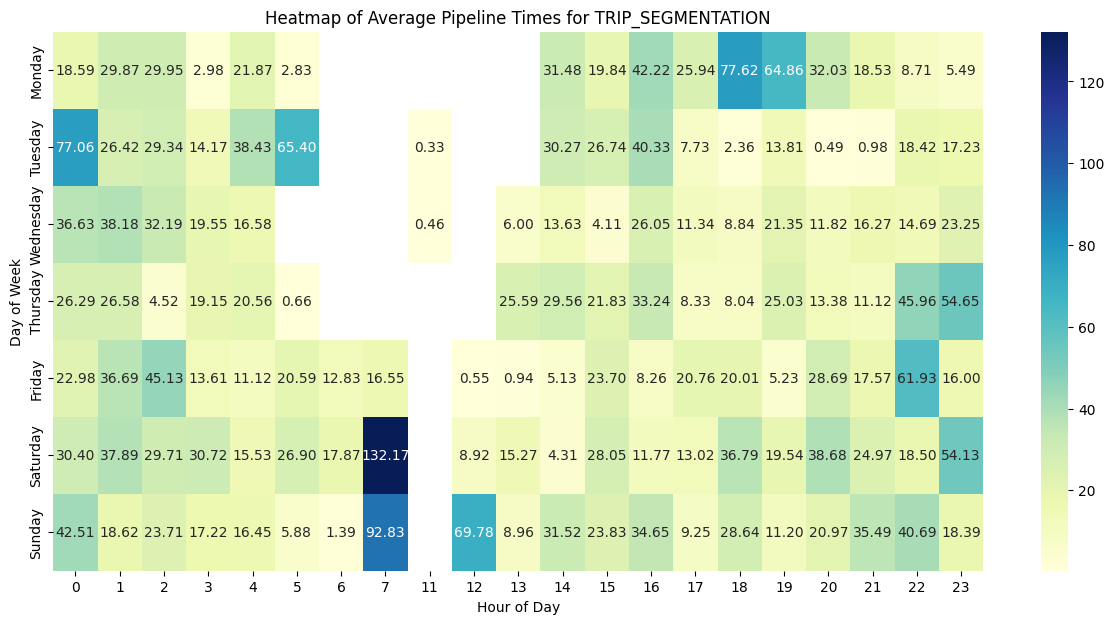

In [12]:
def heatmap_pipeline_times(combined_df, step_name):
    step_df = combined_df[combined_df['data.name'] == step_name].copy()
    
    if step_df.empty:
        print(f"No data found for step: {step_name}")
        return
    
    # Convert timestamp to datetime
    step_df['datetime'] = pd.to_datetime(step_df['metadata.write_ts'], unit='s')
    
    # Extract hour and day of week
    step_df['hour'] = step_df['datetime'].dt.hour
    step_df['day_of_week'] = step_df['datetime'].dt.day_name()
    
    # Create pivot table
    pivot = step_df.pivot_table(values='data.reading', index='day_of_week', columns='hour', aggfunc='mean')
    
    # Reorder days of the week
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    pivot = pivot.reindex(days_order)
    
    # Plot heatmap
    plt.figure(figsize=(15,7))
    sns.heatmap(pivot, cmap='YlGnBu', annot=True, fmt=".2f")
    plt.title(f"Heatmap of Average Pipeline Times for {step_name}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Day of Week")
    plt.show()


heatmap_pipeline_times(df, 'TRIP_SEGMENTATION')


Execution Time Variability per Pipeline Step:
                    data.name  average_time_sec  std_dev_sec  variance_sec2
10          TRIP_SEGMENTATION         24.363153    34.175442    1167.960834
2    CREATE_COMPOSITE_OBJECTS          3.825797     4.169853      17.387673
1            CLEAN_RESAMPLING          2.724287     2.042850       4.173238
7              MODE_INFERENCE          1.932568     1.743826       3.040930
8        SECTION_SEGMENTATION          2.764333     1.621331       2.628713
3    CREATE_CONFIRMED_OBJECTS          1.335022     1.284191       1.649145
12  USER_INPUT_MATCH_INCOMING          0.811679     0.862925       0.744640
5              JUMP_SMOOTHING          0.588767     0.440176       0.193755
11                  USERCACHE          0.102438     0.293309       0.086030
6             LABEL_INFERENCE          0.218143     0.193859       0.037581
4      EXPECTATION_POPULATION          0.075575     0.064282       0.004132
0          ACCURACY_FILTERING          0.

/var/folders/8j/284cnbzn2tzbfljhtsr17gsx2490jk/T/ipykernel_9681/2891362776.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='data.reading', y='data.name', data=df, palette='coolwarm')


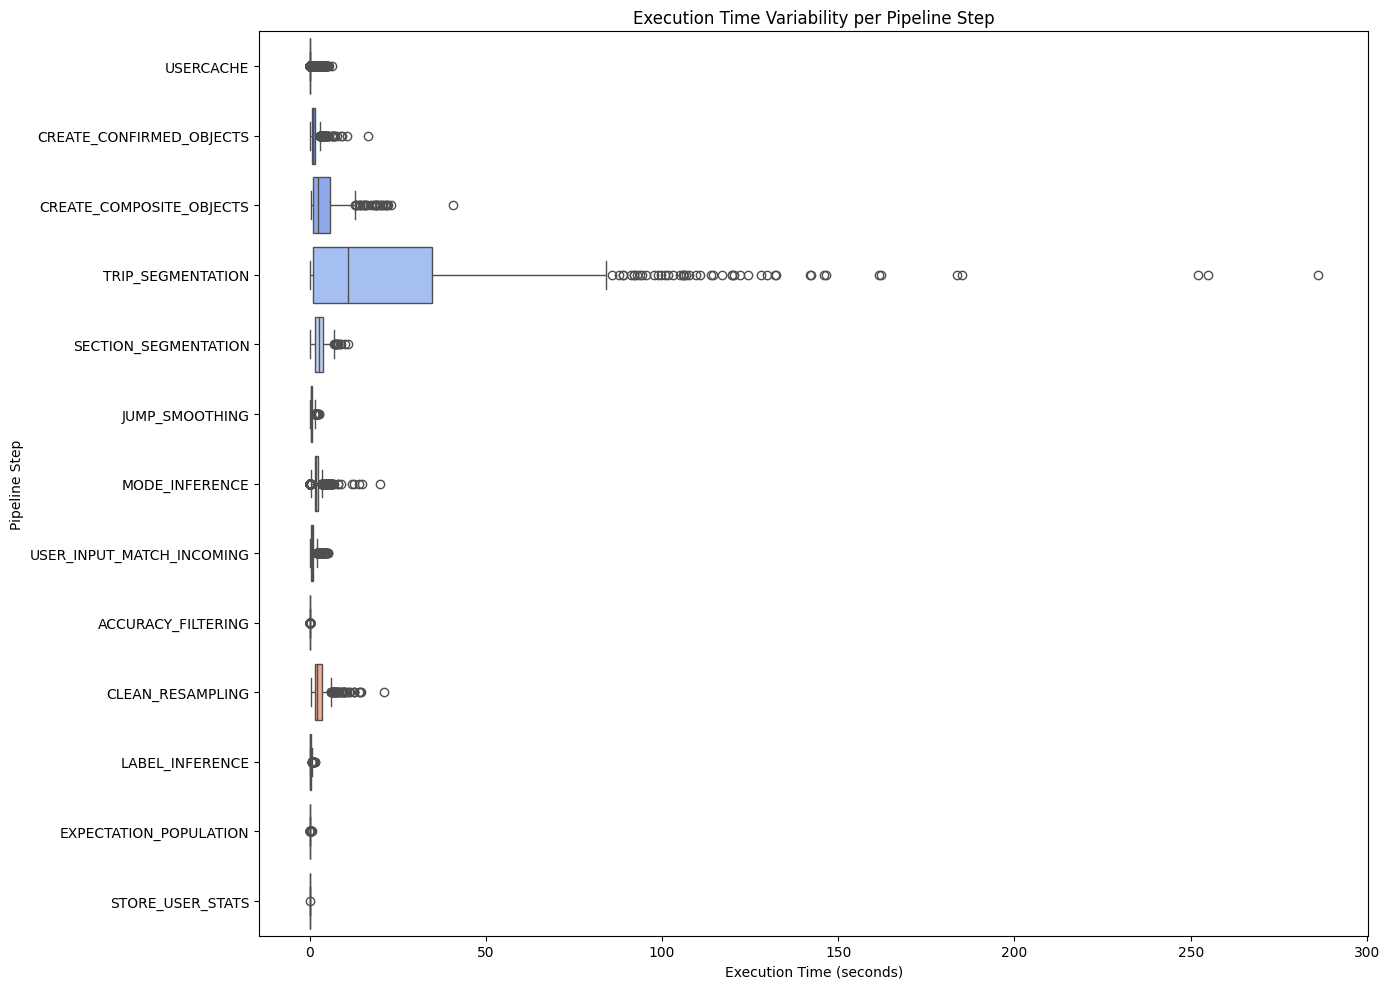

Saved execution time variability to 'execution_time_variability_per_step.csv'


In [13]:
def execution_time_variability_per_step(df):
    variability_df = df.groupby('data.name')['data.reading'].agg(['mean', 'std', 'var']).reset_index()
    variability_df.rename(columns={'mean': 'average_time_sec', 'std': 'std_dev_sec', 'var': 'variance_sec2'}, inplace=True)
    
    # Sort by standard deviation descending
    variability_df = variability_df.sort_values(by='std_dev_sec', ascending=False)
    
    print("\nExecution Time Variability per Pipeline Step:")
    print(variability_df)
    
    # Visualization: Box Plots to visualize variability
    plt.figure(figsize=(14,10))
    sns.boxplot(x='data.reading', y='data.name', data=df, palette='coolwarm')
    plt.title("Execution Time Variability per Pipeline Step")
    plt.xlabel("Execution Time (seconds)")
    plt.ylabel("Pipeline Step")
    plt.tight_layout()
    plt.show()
    
    # Save to CSV
    variability_df.to_csv('execution_time_variability_per_step.csv', index=False)
    print("Saved execution time variability to 'execution_time_variability_per_step.csv'")


execution_time_variability_per_step(df)


Average Proportion of Total Pipeline Time per Step:
                    data.name  average_proportion_percent
10          TRIP_SEGMENTATION                    0.096760
7              MODE_INFERENCE                    0.042982
1            CLEAN_RESAMPLING                    0.040903
8        SECTION_SEGMENTATION                    0.037858
12  USER_INPUT_MATCH_INCOMING                    0.028341
2    CREATE_COMPOSITE_OBJECTS                    0.028005
3    CREATE_CONFIRMED_OBJECTS                    0.021936
11                  USERCACHE                    0.016746
5              JUMP_SMOOTHING                    0.007217
6             LABEL_INFERENCE                    0.002128
4      EXPECTATION_POPULATION                    0.001036
9            STORE_USER_STATS                    0.000426
0          ACCURACY_FILTERING                    0.000390


/var/folders/8j/284cnbzn2tzbfljhtsr17gsx2490jk/T/ipykernel_9681/3938384783.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='average_proportion_percent', y='data.name', data=step_contribution_df, palette='coolwarm')


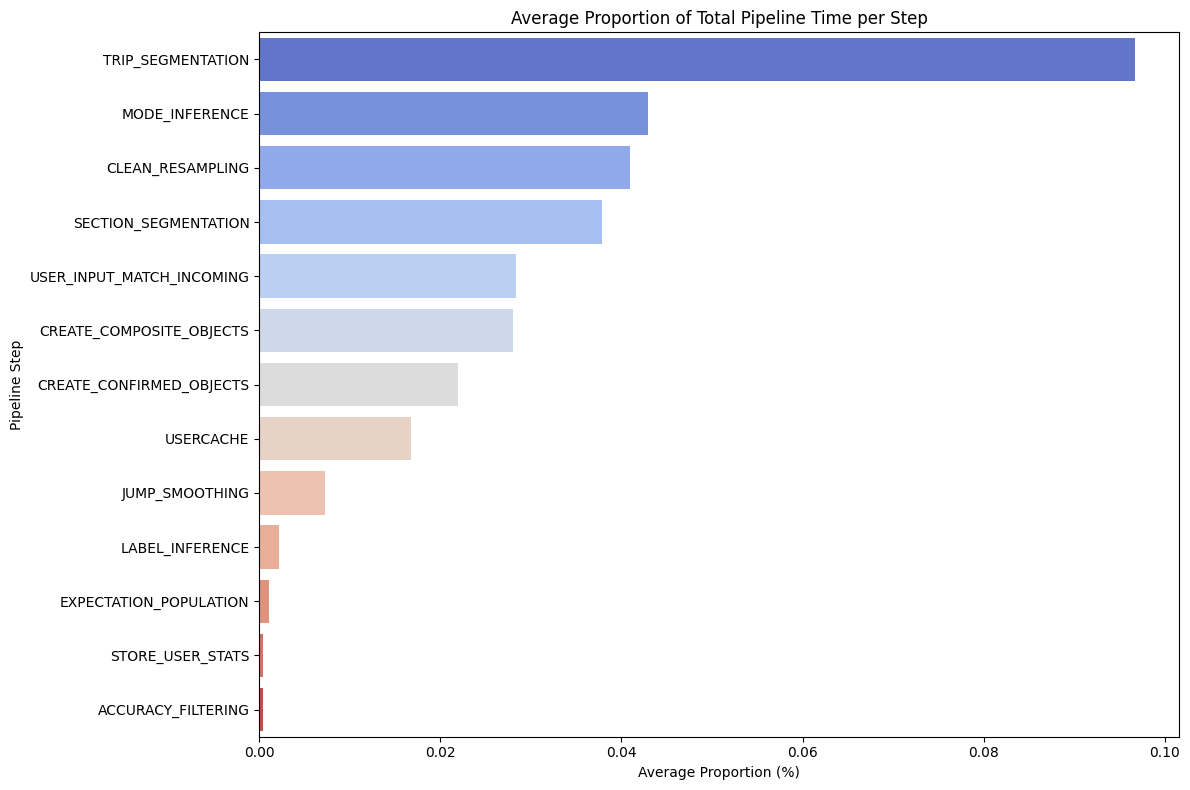

Saved step contribution analysis to 'average_proportion_total_time_per_step.csv'


In [14]:
def step_contribution_analysis(df):
    # Calculate total pipeline time per execution
    total_time_per_execution = df.groupby(['user_id', 'metadata.key'])['data.reading'].sum().reset_index()
    total_time_per_execution.rename(columns={'data.reading': 'total_pipeline_time_sec'}, inplace=True)
    
    # Merge total pipeline time back to the main DataFrame
    df = df.merge(total_time_per_execution, on=['user_id', 'metadata.key'])
    
    # Calculate proportion of each step's time to the total pipeline time
    df['step_proportion_percent'] = (df['data.reading'] / df['total_pipeline_time_sec']) * 100
    
    # Aggregate average proportion per step
    step_contribution_df = df.groupby('data.name')['step_proportion_percent'].mean().reset_index()
    step_contribution_df.rename(columns={'step_proportion_percent': 'average_proportion_percent'}, inplace=True)
    
    # Sort descending
    step_contribution_df = step_contribution_df.sort_values(by='average_proportion_percent', ascending=False)
    
    print("\nAverage Proportion of Total Pipeline Time per Step:")
    print(step_contribution_df)
    
    # Visualization: Horizontal Bar Chart
    plt.figure(figsize=(12,8))
    sns.barplot(x='average_proportion_percent', y='data.name', data=step_contribution_df, palette='coolwarm')
    plt.title("Average Proportion of Total Pipeline Time per Step")
    plt.xlabel("Average Proportion (%)")
    plt.ylabel("Pipeline Step")
    plt.tight_layout()
    plt.show()
    
    # Save to CSV
    step_contribution_df.to_csv('average_proportion_total_time_per_step.csv', index=False)
    print("Saved step contribution analysis to 'average_proportion_total_time_per_step.csv'")

step_contribution_analysis(df)